# Proyecto Final - IA - Machine Learning
## Arquitectura 3: LSTM para Generación de Secuencias Musicales (MIDI)

Red recurrente (LSTM) usando TensorFlow/Keras para modelar secuencias musicales a partir de archivos MIDI y generar nueva música.


## Introduccion y objetivo

### Descripción del problema

El objetivo es entrenar un modelo basado en LSTM que aprenda patrones de notas
a partir de archivos MIDI y pueda:

1. Predecir la **siguiente nota** dada una secuencia de notas anteriores.
2. Generar nuevas **secuencias musicales** (melodías) de forma automática.

Se trabajará con secuencias discretas de **pitches MIDI**, ignorando por simplicidad la duración y la dinámica, para mantener el foco en la arquitectura de la red.

### ¿Por qué este dataset?

- Está en los recomendados.
- La descripcion me gustó: "characterized by distinctive and mellow jazz-like beats"
Los datos musicales son un ejemplo clásico de **datos secuenciales**.

Se usará **TensorFlow/Keras** y `pretty_midi` para manipular los MIDI.

### Imports e inicializacion

In [ ]:
!pip install pretty_midi --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

import pretty_midi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


### Dataset y archivos

In [ ]:
path = kagglehub.dataset_download("zakarii/lofi-hip-hop-midi")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lofi-hip-hop-midi' dataset.
Path to dataset files: /kaggle/input/lofi-hip-hop-midi


In [ ]:
MIDI_DIR = "/kaggle/input/lofi-hip-hop-midi"

midi_files = glob.glob(os.path.join(MIDI_DIR, "**", "*.mid"), recursive=True)
midi_files += glob.glob(os.path.join(MIDI_DIR, "**", "*.midi"), recursive=True)

print("Número de archivos MIDI encontrados:", len(midi_files))
midi_files[:5]

Número de archivos MIDI encontrados: 93


['/kaggle/input/lofi-hip-hop-midi/Piano 2 MIDI.mid',
 '/kaggle/input/lofi-hip-hop-midi/Cymatics - Lofi MIDI 20 - G Min.mid',
 '/kaggle/input/lofi-hip-hop-midi/Lofi Piano MIDI.mid',
 '/kaggle/input/lofi-hip-hop-midi/Cymatics - Eternity MIDI 22 - B Min.mid',
 '/kaggle/input/lofi-hip-hop-midi/Piano MIDI (3).mid']

### Exploracion de datos

In [ ]:
def extract_melody_pitches(pm: pretty_midi.PrettyMIDI):
    """
    Extrae una melodía simple como secuencia de pitches:
    - Tomamos el primer instrumento que tenga notas.
    - Ordenamos las notas por tiempo de inicio.
    - Devolvemos lista de n.pitch (valores int 0-127).
    """
    if not pm.instruments:
        return []

    inst = None
    for ins in pm.instruments:
        if len(ins.notes) > 0:
            inst = ins
            break
    if inst is None:
        return []

    notes = sorted(inst.notes, key=lambda n: n.start)
    pitches = [n.pitch for n in notes]
    return pitches

if len(midi_files) > 0:
    pm_test = pretty_midi.PrettyMIDI(midi_files[0])
    pitches_test = extract_melody_pitches(pm_test)
    print("Ejemplo de pitches (primer archivo):", pitches_test[:50])
else:
    print("No se encontraron archivos MIDI. Revisa MIDI_DIR.")

Ejemplo de pitches (primer archivo): [85, 87, 89, 94, 92, 89, 87, 85, 82, 85, 85, 87, 89, 94, 92, 89, 87, 85, 82, 85]


In [ ]:
all_pitches = []

for path in midi_files:
    try:
        pm = pretty_midi.PrettyMIDI(path)
        pitches = extract_melody_pitches(pm)
        if len(pitches) > 50:
            all_pitches.append(pitches)
    except Exception as e:
        print("Error al procesar:", path, "->", e)

print("Número de secuencias válidas:", len(all_pitches))
lengths = [len(seq) for seq in all_pitches]
print("Longitud media de secuencia:", np.mean(lengths))

Número de secuencias válidas: 26
Longitud media de secuencia: 73.5


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


### Distribucion de notas y vocabulario de notas

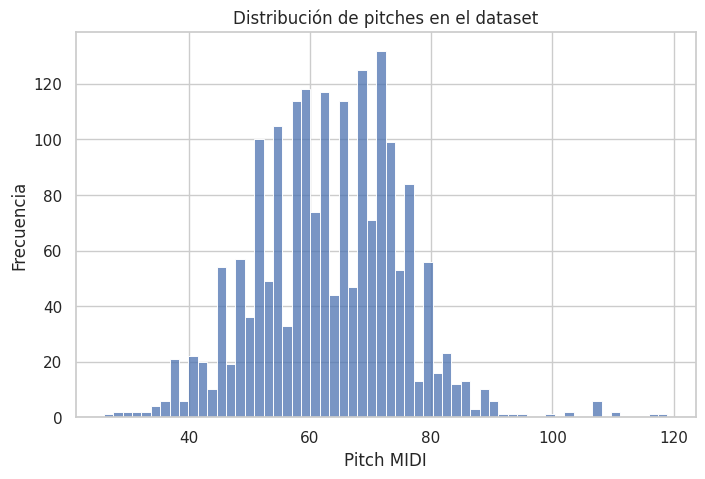

Min pitch: 26 Max pitch: 119


In [ ]:
flat_pitches = [p for seq in all_pitches for p in seq]

plt.figure()
sns.histplot(flat_pitches, bins=60, kde=False)
plt.xlabel("Pitch MIDI")
plt.ylabel("Frecuencia")
plt.title("Distribución de pitches en el dataset")
plt.show()

print("Min pitch:", np.min(flat_pitches), "Max pitch:", np.max(flat_pitches))

In [ ]:
unique_pitches = sorted(list(set(flat_pitches)))
print("Número de notas distintas (vocab_size):", len(unique_pitches))

pitch_to_idx = {p: i for i, p in enumerate(unique_pitches)}
idx_to_pitch = {i: p for p, i in pitch_to_idx.items()}
vocab_size = len(unique_pitches)

Número de notas distintas (vocab_size): 74


In [ ]:
SEQ_LENGTH = 50

X_sequences = []
y_targets = []

for seq in all_pitches:
    idx_seq = [pitch_to_idx[p] for p in seq]
    for i in range(len(idx_seq) - SEQ_LENGTH):
        X_sequences.append(idx_seq[i:i+SEQ_LENGTH])
        y_targets.append(idx_seq[i+SEQ_LENGTH])

X_sequences = np.array(X_sequences, dtype=np.int32)
y_targets = np.array(y_targets, dtype=np.int32)

print("X shape:", X_sequences.shape)
print("y shape:", y_targets.shape)

X shape: (611, 50)
y shape: (611,)


In [ ]:
from collections import Counter

counts = Counter(y_targets)
print("Número de clases totales:", len(counts))

valid_classes = [cls for cls, cnt in counts.items() if cnt >= 2]
print("Clases con >=2 muestras:", len(valid_classes))

mask = np.isin(y_targets, valid_classes)
X_sequences_filtered = X_sequences[mask]
y_targets_filtered = y_targets[mask]

print("X_sequences_filtered shape:", X_sequences_filtered.shape)
print("y_targets_filtered shape:", y_targets_filtered.shape)

counts_filtered = Counter(y_targets_filtered)
print("Mínimo de muestras por clase después de filtrar:",
      min(counts_filtered.values()))

Número de clases totales: 63
Clases con >=2 muestras: 49
X_sequences_filtered shape: (597, 50)
y_targets_filtered shape: (597,)
Mínimo de muestras por clase después de filtrar: 2


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_sequences_filtered,
    y_targets_filtered,
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify=y_targets_filtered
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify=y_train_val
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (483, 50) Val: (54, 50) Test: (60, 50)


### Convertir a Dataset

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Definicion del modelo

In [ ]:
EMBEDDING_DIM = 128
LSTM_UNITS = 256

def build_lstm_model(seq_length=SEQ_LENGTH, vocab_size=vocab_size):
    model = keras.Sequential(
        [
            layers.Embedding(
                input_dim=vocab_size,
                output_dim=EMBEDDING_DIM,
                input_length=seq_length
            ),
            layers.LSTM(LSTM_UNITS, return_sequences=True),
            layers.Dropout(0.3),
            layers.LSTM(LSTM_UNITS),
            layers.Dropout(0.3),
            layers.Dense(vocab_size, activation="softmax"),
        ],
        name="MusicLSTM"
    )
    return model

model = build_lstm_model()
model.summary()

Model: "MusicLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 30
LEARNING_RATE = 1e-3

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint_path = "best_lstm_music.keras"

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True
    )
]

### Entrenamiento

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.0444 - loss: 4.2748 - val_accuracy: 0.0741 - val_loss: 3.8101
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0727 - loss: 3.8685 - val_accuracy: 0.0926 - val_loss: 3.5011
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0796 - loss: 3.5264 - val_accuracy: 0.0741 - val_loss: 3.3100
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0670 - loss: 3.4824 - val_accuracy: 0.0741 - val_loss: 3.2841
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0981 - loss: 3.4090 - val_accuracy: 0.0741 - val_loss: 3.3118
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1015 - loss: 3.3750 - val_accuracy: 0.0741 - val_loss: 3.2413
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0955 - loss: 3.3627 - val_accuracy: 0.0741 - val_loss: 3.2383
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1184 - loss: 3.2553 - val_accuracy: 0.1481 - val_loss: 3.1659


### Curvas de entrenamiento

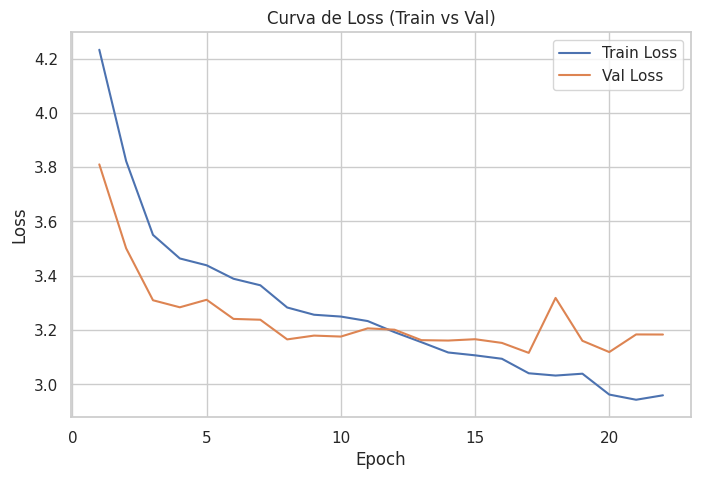

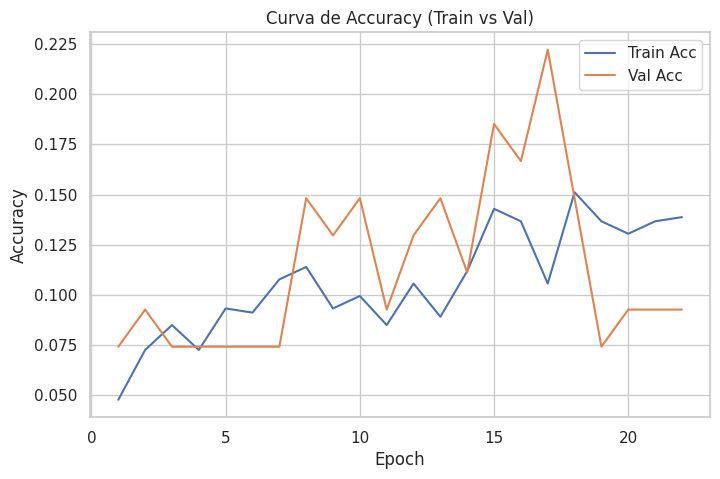

In [ ]:
history_dict = history.history
epochs_range = range(1, len(history_dict["loss"]) + 1)

plt.figure()
plt.plot(epochs_range, history_dict["loss"], label="Train Loss")
plt.plot(epochs_range, history_dict["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Loss (Train vs Val)")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, history_dict["accuracy"], label="Train Acc")
plt.plot(epochs_range, history_dict["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Curva de Accuracy (Train vs Val)")
plt.legend()
plt.show()

### Evaluacion del test

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

y_true = []
y_pred = []

for X_batch, y_batch in test_ds:
    preds = model.predict(X_batch, verbose=0)
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

print("Test Accuracy (sklearn):", acc)
print("Test Precision (weighted):", precision)
print("Test Recall (weighted):", recall)
print("Test F1-score (weighted):", f1)

print("\nClassification report (por nota):")
print(classification_report(y_true, y_pred, digits=3))

Test Loss: 3.0563
Test Accuracy: 0.0833
Test Accuracy (sklearn): 0.08333333333333333
Test Precision (weighted): 0.018183760683760684
Test Recall (weighted): 0.08333333333333333
Test F1-score (weighted): 0.029444444444444443

Classification report (por nota):
              precision    recall  f1-score   support

          10      0.000     0.000     0.000         1
          13      0.000     0.000     0.000         1
          15      0.000     0.000     0.000         1
          17      0.000     0.000     0.000         1
          18      0.000     0.000     0.000         1
          21      0.000     0.000     0.000         1
          22      0.000     0.000     0.000         1
          23      0.000     0.000     0.000         1
          24      0.333     1.000     0.500         1
          25      0.000     0.000     0.000         1
          26      0.000     0.000     0.000         2
          27      0.000     0.000     0.000         2
          28      0.000     0.000     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Matriz de confusion

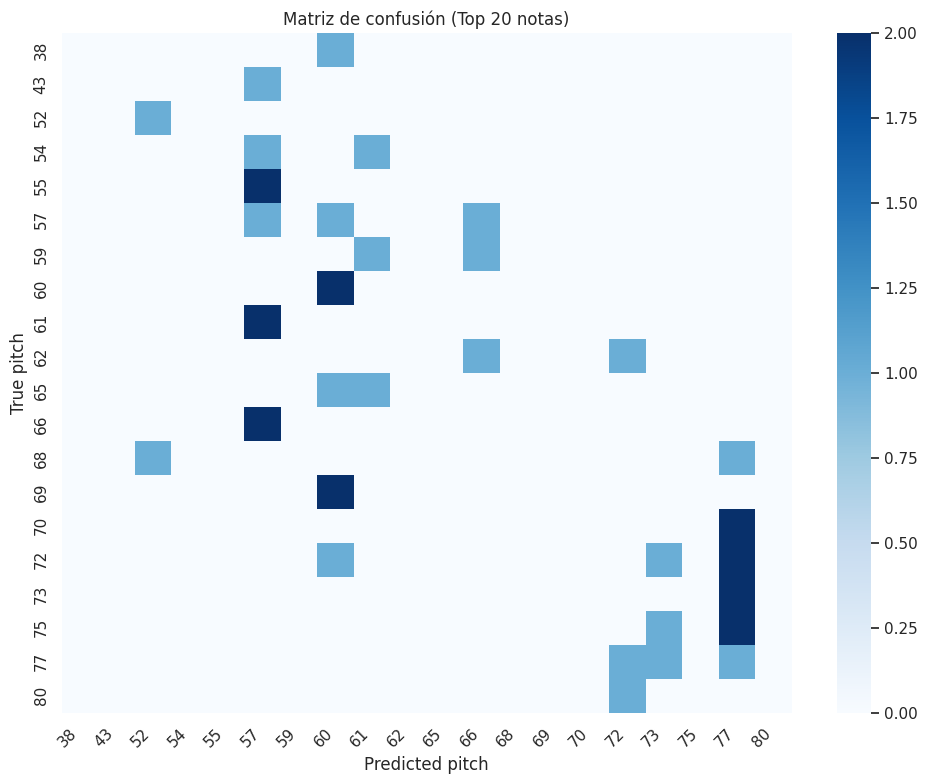

In [ ]:
note_counts = Counter(y_true)
most_common = note_counts.most_common(20)  # top 20 notas
top_indices = sorted([idx for idx, _ in most_common])

# Filtrar y_true y y_pred solo para esas notas
mask = np.isin(y_true, top_indices)
y_true_top = y_true[mask]
y_pred_top = y_pred[mask]

cm = confusion_matrix(y_true_top, y_pred_top, labels=top_indices)

labels_str = [str(idx_to_pitch[i]) for i in top_indices]  # pitch real

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=labels_str,
    yticklabels=labels_str
)
plt.xlabel("Predicted pitch")
plt.ylabel("True pitch")
plt.title("Matriz de confusión (Top 20 notas)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Generar una nueva melodia

In [ ]:
def sample_with_temperature(preds, temperature=1.0):
    """
    preds: vector de probabilidades (vocab_size)
    Devuelve índice sampleado usando temperatura.
    """
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_note_sequence(model, seed_seq, length=100, temperature=1.0):
    """
    seed_seq: lista de índices (len = SEQ_LENGTH)
    """
    generated = list(seed_seq)
    for _ in range(length):
        input_seq = np.array(generated[-SEQ_LENGTH:], dtype=np.int32)[None, :]
        preds = model.predict(input_seq, verbose=0)[0]
        next_idx = sample_with_temperature(preds, temperature)
        generated.append(next_idx)
    return generated

In [ ]:
rand_idx = np.random.randint(0, len(X_train))
seed_seq = X_train[rand_idx]

generated_idxs = generate_note_sequence(
    model,
    seed_seq,
    length=150,
    temperature=0.8
)

generated_pitches = [idx_to_pitch[i] for i in generated_idxs]

pm_gen = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(program=0)
start = 0.0
duration = 0.5

for pitch in generated_pitches:
    note = pretty_midi.Note(
        velocity=80,
        pitch=int(pitch),
        start=start,
        end=start + duration
    )
    instrument.notes.append(note)
    start += duration

pm_gen.instruments.append(instrument)
output_path = "generated_melody.mid"
pm_gen.write(output_path)
print("Archivo generado:", output_path)

Archivo generado: generated_melody.mid


## Resumen, analisis y conclusiones

La arquitectura utilizada es:

- **Entrada:** secuencia de longitud 50 de índices de notas MIDI.
- **Capa Embedding:** `Embedding(vocab_size, 128)` para mapear cada nota a un vector denso.
- **LSTM 1:** 256 unidades, `return_sequences=True`.
- **Dropout:** 0.3
- **LSTM 2:** 256 unidades.
- **Dropout:** 0.3
- **Salida:** `Dense(vocab_size, softmax)` que predice la probabilidad de cada posible nota siguiente.

**Función de pérdida:** `sparse_categorical_crossentropy`  
**Optimizador:** Adam (learning rate = 1e-3)  
**Batch size:** 64  
**Épocas:** hasta 30, con EarlyStopping en `val_loss`.

### Interpretación de Resultados

- La accuracy de predicción de la siguiente nota en el conjunto de test fue de 0.0833.

### Limitaciones del Modelo

- Solo modelamos el **pitch**, ignorando duración, intensidad y acordes.
- La melodía generada puede sonar monótona o repetitiva si el dataset es pequeño.
- El modelo no tiene conocimiento explícito de la tonalidad, armonía o estructura musical a alto nivel.

### Posibles Mejoras

- Incluir **duración** y **velocidad** como parte del estado.
- Usar arquitecturas más avanzadas.
- Aumentar el tamaño y la diversidad del dataset MIDI.